In [1]:
!pip install rasterio


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
from rasterio.warp import transform
from rasterio.transform import rowcol, xy
from rasterio.mask import mask

In [3]:
#The dataset includes global urban land in 1992, 1996, 2000, 2006, 2010, 2016. In each data, the digital number of 1 denotes urban land, while the digital number of 0 denotes non-urban land.
#The data format: TIFF
#The spatial extent: −180° to 180° in longitude and −65° to 75° in latitude
#The geographic coordinate system: WGS1984
#The spatial resolution: 30-arc-second (about 1 km).

#QGISで確認
#north: 74.996615080
#west:  -179.00000000
#south: -56.025607100
#east:  179.991355960
#horizontal: 0.00899322 #39918
#vertical:   0.00899322 #14569
path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/org/He_2019/Global_Urban_Land_2010.tif'

In [13]:
with rasterio.open(path) as src:
    # 投影法の情報を取得
    # これらを用いてピクセル座標を実際の地理座標に変換することができる
    crs = src.crs # EPSG: 4326=WGS84 (crs: coordinate reference system, 座標参照系)
    transform_matrix = src.transform # | 0.01, 0.00, -179.00| (投影座標系: 地球の曲面を底面に投影する方法) (アフィン変換行列)
    rows, cols = src.shape
    print(transform_matrix)
    
# ピクセル座標から緯度経度座標に変換
#row_indices = range(rows)
#col_indices = range(cols)
#lon_lats = [xy(transform_matrix, r, c) for r in row_indices for c in col_indices]

| 0.01, 0.00,-179.00|
| 0.00,-0.01, 75.00|
| 0.00, 0.00, 1.00|


In [47]:
south = -90
north = 90
west = -180
east = 180
grid_count_lat = 2160
grid_count_lon = 4320

import numpy as np

# 参照データのパラメータ
ref_lon_step = 0.00899322
ref_lat_step = 0.00899322
ref_north = 74.996615080
ref_south = -56.025607100
ref_west = -179.00000000
ref_east = 179.991355960

# 新データのパラメータ
new_lon_step = 0.0833
new_lat_step = 0.0833
new_north = 90.0000
new_south = -90.0000
new_west = -180.0000
new_east = 180.0000

# 参照データと新データのサイズ
Image.MAX_IMAGE_PIXELS = None
image = Image.open(path)
ref_data = np.array(image)
new_data = np.zeros((2160, 4320))  # 新データ

# 新しいデータグリッドに対して処理
for i in range(grid_count_lat):  # 緯度方向
    for j in range(grid_count_lon):  # 経度方向
        # 新しいデータグリッドの緯度経度範囲を計算
        new_lat_start = new_north - i * new_lat_step
        new_lat_end = new_north - (i + 1) * new_lat_step
        new_lon_start = new_west + j * new_lon_step
        new_lon_end = new_west + (j + 1) * new_lon_step

        # 参照データの範囲内にあるかチェック
        if new_lat_end < ref_south or new_lat_start > ref_north:
            continue  # 参照データ範囲外の場合はスキップ
        if new_lon_end < ref_west or new_lon_start > ref_east:
            continue
        
        # 該当する参照データの範囲を取得
        row_start = int((ref_north - new_lat_start) / ref_lat_step)
        row_end = int((ref_north - new_lat_end) / ref_lat_step)
        col_start = int((new_lon_start - ref_west) / ref_lon_step)
        col_end = int((new_lon_end - ref_west) / ref_lon_step)

        # 参照データの範囲内に1があれば、新データのグリッドを1に設定
        average = np.mean(ref_data[row_start:row_end+1, col_start:col_end+1])
        if np.any(ref_data[row_start:row_end+1, col_start:col_end+1] == 1):
        #if average>0.1:
            new_data[i, j-1] = 1

# 結果の新データを保存または処理

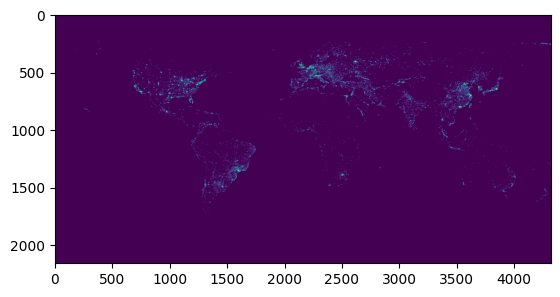

In [48]:
plt.imshow(new_data)

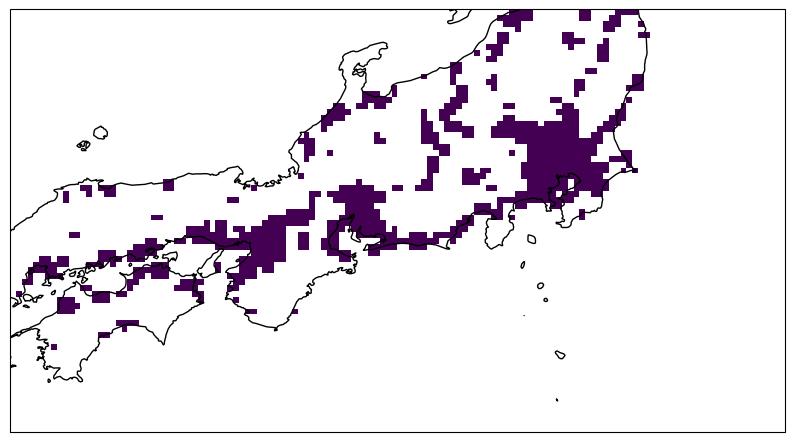

In [49]:
def geography(one, twho, three, four):
    #
    a = 2160
    b = 4320
    gl5shape = (a, b)
    #
    resolution = 12
    upperindex = (90-four)*resolution
    lowerindex = (90-three)*resolution
    leftindex = (180+one)*resolution
    rightindex = (180+two)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (one, two, three, four)  
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent
    
# めちゃくちゃずれてる
#drawings
one = 132
two = 143
three = 32
four = 38

upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(one, two, three, four)

resized_cropped = new_data[upperindex:lowerindex, leftindex:rightindex]
resized_masked = np.ma.masked_where(resized_cropped==0, resized_cropped)

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=projection)
im = ax.imshow(resized_masked,
               extent=img_extent, transform=projection)
ax.coastlines()
plt.show()

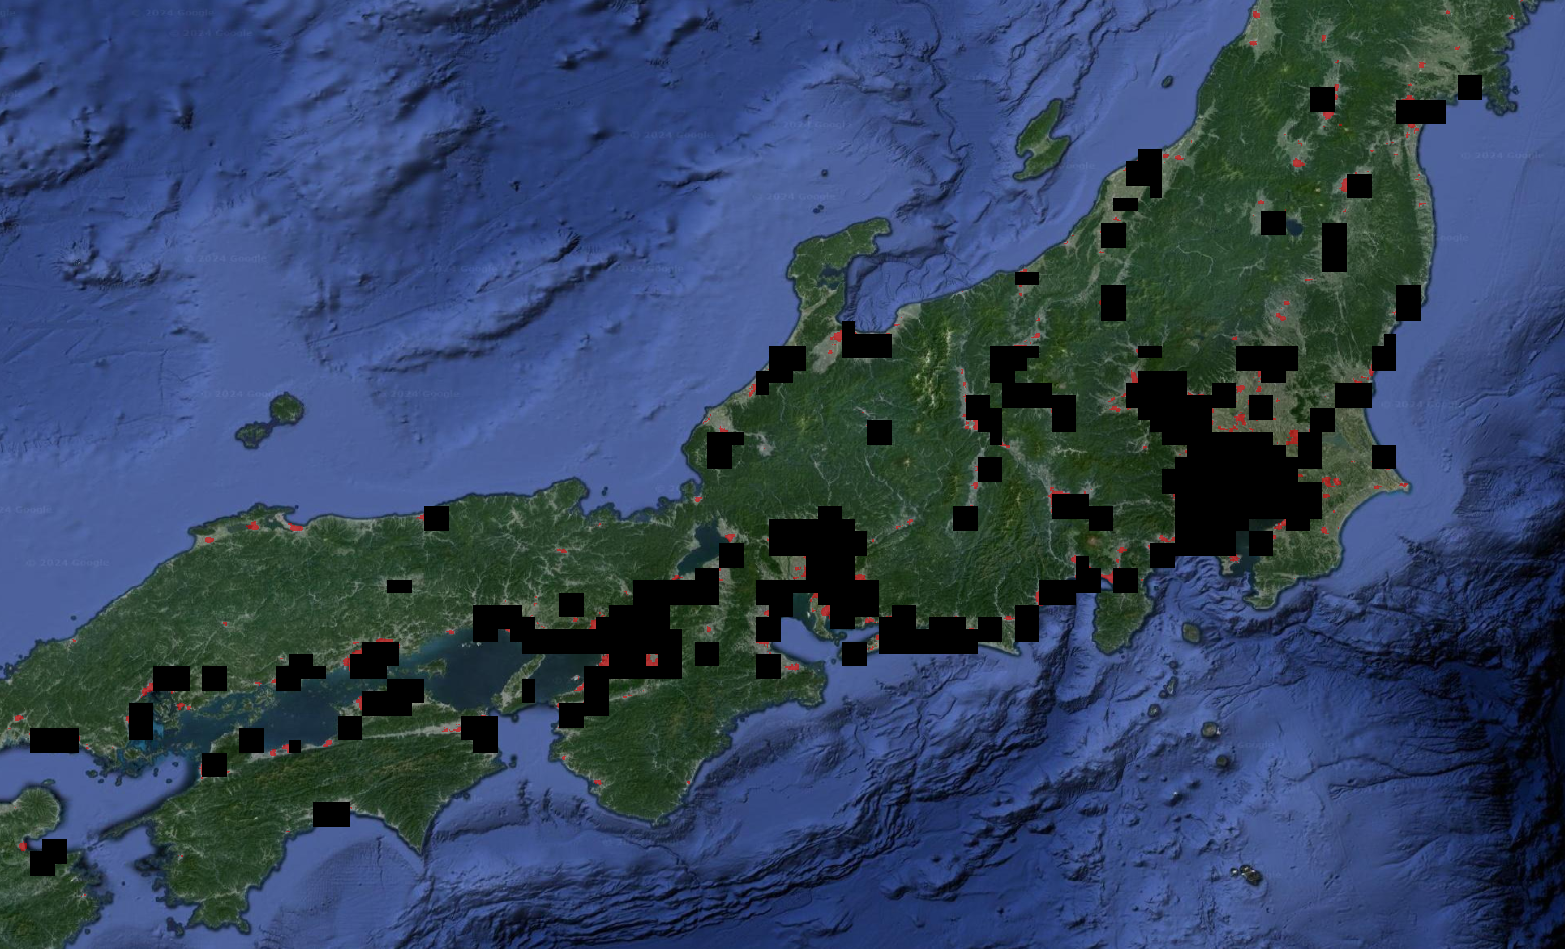

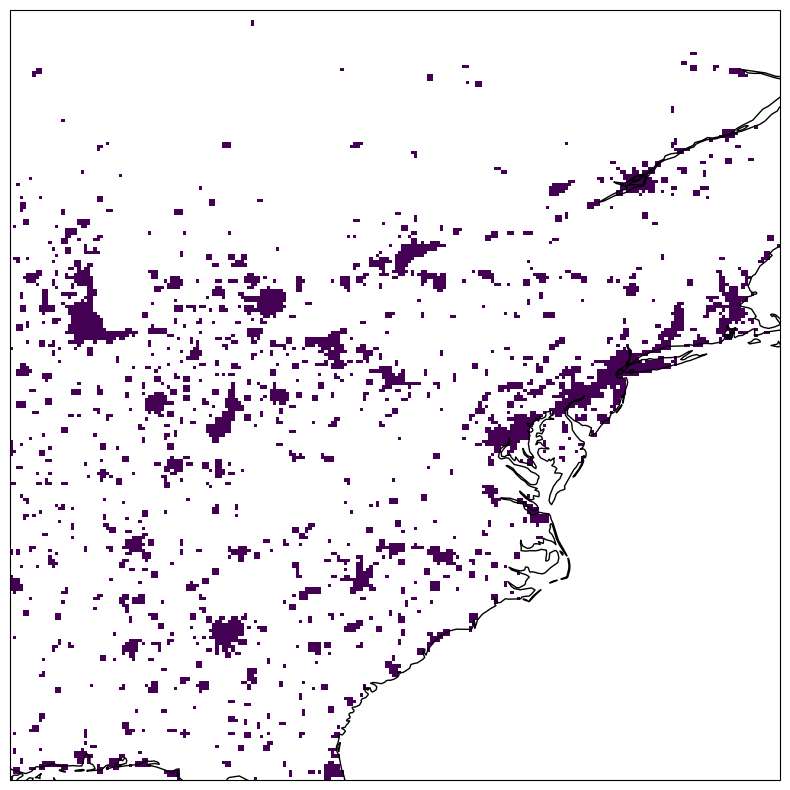

In [55]:
one = -90
two = -70
three = 30
four = 50

upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(one, two, three, four)

resized_cropped = new_data[upperindex:lowerindex, leftindex:rightindex]
resized_masked = np.ma.masked_where(resized_cropped==0, resized_cropped)

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=projection)
im = ax.imshow(resized_masked,
               extent=img_extent, transform=projection)
ax.coastlines()
plt.show()

In [56]:
savefile = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/urb_msk_/Global_Urban_Land_2010_upscaled.gl5'
#new_data.astype(np.int32).tofile(savefile)

In [60]:
#############
# verification
ref_path = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/vld_cty_/city_clrd0000.gl5'
ref = np.fromfile(ref_path, dtype='float32').reshape(2160, 4320)

count = 0
true = 0
false = 0

for i in range(2160):
    for j in range(4320):
        if ref[i,j] != 0:
            if new_data[i,j] == 1:
                true += 1
            else:
                false += 1
            count += 1

print(f'true:{true}, false:{false}, count:{count}')
print(true/count * 100)

true:9423, false:5146, count:14569
64.67842679662297


In [61]:
# verification
savetext = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/cty_lst_/he_validation.txt'

def write_text(save_path, index, rate, true, false, count):
    if index == 1:
        with open(save_path, 'w') as file:
            filw.write(f"{index}|{rate}|{true}|{false}|{count}")
    else:
        with open(save_path, 'a') as file:
            filw.write(f"{index}|{rate}|{true}|{false}|{count}")

city_num = 1
ref_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/vld_cty_/city_{city_num:08}.gl5'
ref = np.fromfile(ref_path, dtype='float32').reshape(2160, 4320)

count = 0
true = 0
false = 0

for i in range(2160):
    for j in range(4320):
        if ref[i,j] != 0:
            if new_data[i,j] == 1:
                true += 1
            else:
                false += 1
            count += 1

print(f'true:{true}, false:{false}, count:{count}')
print(true/count * 100)

true:85, false:8, count:93
91.39784946236558


In [67]:
# verification
import os

savetext = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/cty_lst_/he_validation.txt'

def write_text(save_path, index, rate, true, false, count):
    if index == 1:
        with open(save_path, 'w') as file:
            file.write(f"{index}|{rate}|{true}|{false}|{count}")
    else:
        with open(save_path, 'a') as file:
            filw.write(f"{index}|{rate}|{true}|{false}|{count}")

for num in range(1, 1861):
    ref_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/vld_cty_/city_{num:08}.gl5'
    if not os.path.exists(ref_path):
        continue
        
    ref = np.fromfile(ref_path, dtype='float32').reshape(2160, 4320)
    
    count = 0
    true = 0
    false = 0
    
    for i in range(2160):
        for j in range(4320):
            if ref[i,j] != 0:
                if new_data[i,j] == 1:
                    true += 1
                else:
                    false += 1
                count += 1

    rate = true/count
    
    write_text(savetext, num, rate, true, false, count)

NameError: name 'filw' is not defined